In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt

import xgboost as xgb

from sklearn.metrics import accuracy_score, classification_report

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#df = pd.read_csv('../data/pct_diff_df.csv')
df = pd.read_csv(drive_dir + 'pct_diff_df.csv')
df = df.fillna(0)

In [3]:
df.head()

,Y,home_win,elo_pct_diff,obp_pct_diff,fip_pct_diff,whip_pct_diff,k/9_pct_diff,hr/9_pct_diff,k/bb_pct_diff,iso_pct_diff,rest_pct_diff
0,2001,1.0,1.360396,-2.977845,-21.533639,-8.380988,5.602914,-4.176921,20.477432,16.239572,0.0
1,2001,1.0,3.117843,8.985458,-36.793204,0.217176,1.487938,-25.189709,4.452231,23.914199,0.0
2,2001,1.0,-1.002459,0.331871,2.966752,-4.004756,3.096863,4.987071,0.525930,-8.999695,0.0
3,2001,1.0,2.377165,1.970596,-62.331909,-10.774250,11.794451,-33.620825,25.785465,20.430700,0.0
4,2001,1.0,1.684054,4.236467,-33.069380,-11.011642,17.410484,2.559202,30.937780,9.115030,0.0


In [4]:
df['home_win'] = df['home_win'].astype(int)

In [5]:
train = df[df['Y'] <= 2015]
test = df[df['Y'] > 2015]

In [6]:
train = train.drop('Y', axis=1)
test= test.drop('Y', axis=1)

In [7]:
X_train = train.drop('home_win', axis=1)
y_train = train.home_win
X_test = test.drop('home_win', axis=1)
y_test = test.home_win

In [8]:
model = xgb.XGBClassifier()
xgb_model = model.fit(X_train, y_train)

In [9]:
preds = xgb_model.predict(X_test)

In [10]:
accuracy_score(y_test, preds)

0.6250257254579131

In [11]:
model = xgb.XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=300,)# importance_type='total_gain')
xgb_m = model.fit(X_train, y_train)

In [12]:
preds = xgb_m.predict(X_test)

In [13]:
accuracy_score(y_test, preds)

0.6271866639226178

In [25]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57      4551
           1       0.63      0.71      0.67      5167

    accuracy                           0.63      9718
   macro avg       0.63      0.62      0.62      9718
weighted avg       0.63      0.63      0.62      9718



In [14]:
featuredf = pd.DataFrame(xgb_m.feature_importances_, X_train.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=False)

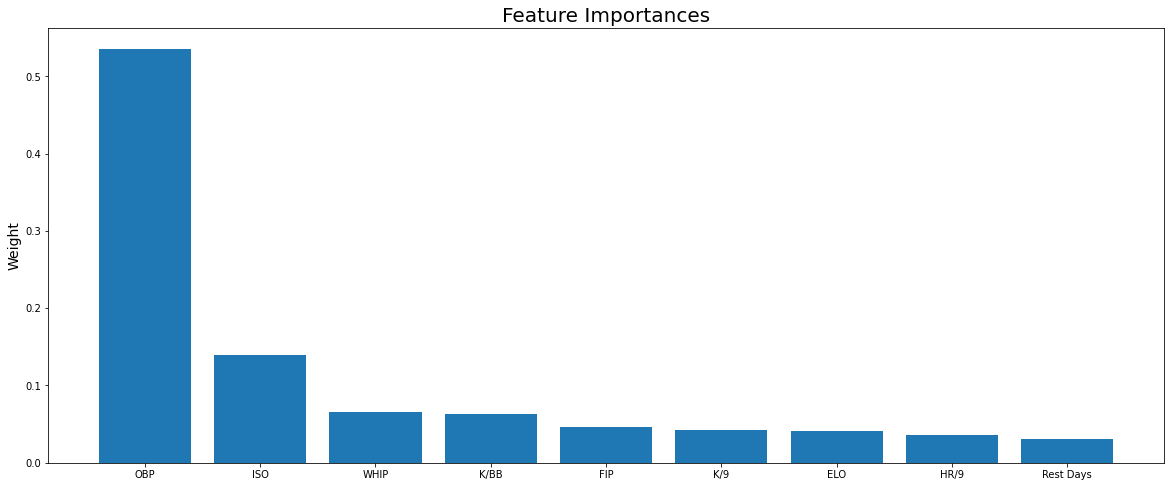

In [15]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.bar(x, y)
plt.xticks([0,1,2,3,4,5,6,7,8], ['OBP', 'ISO', 'WHIP', 'K/BB', 'FIP', 'K/9', 'ELO', 'HR/9', 'Rest Days'])
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14)
plt.savefig(drive_dir + 'feature_importance.png');

In [17]:
!pip install interpret

     |████████████████████████████████| 5.2MB 5.7MB/s 
     |████████████████████████████████| 5.3MB 48.6MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 1.8MB 46.1MB/s 
     |████████████████████████████████| 3.6MB 43.8MB/s 
     |████████████████████████████████| 471kB 55.7MB/s 
     |████████████████████████████████| 276kB 55.1MB/s 
     |████████████████████████████████| 788kB 50.3MB/s 
     |████████████████████████████████| 122kB 37.0MB/s 
     |████████████████████████████████| 860kB 50.5MB/s 
     |████████████████████████████████| 327kB 57.3MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 245kB 59.3MB/s 
     |████████████████████████████████| 1.0MB 47.7MB/s 
     |████████████████████████████████| 3.5MB 50.2MB/s 
     |████████████████████████████████| 194kB 56.7MB/s 
     |████████████████████████████████| 358kB 56.8MB/s 
     |████████████████████████████████| 358kB 57.7MB/

In [18]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,
                              early_stopping_tolerance=0.0001,
                              feature_names=['elo_pct_diff', 'obp_pct_diff',
                                             'fip_pct_diff', 'whip_pct_diff',
                                             'k/9_pct_diff', 'hr/9_pct_diff',
                                             'k/bb_pct_diff', 'iso_pct_diff',
                                             'rest_pct_diff'],
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous'],
                              inner_bags=0, interactions=0, learning_rate=0.01,
                              mains='all', max_bins=255

In [19]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

/usr/local/lib/python3.6/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_envs


In [21]:
ebm_test = X_test[:200]
emb_test_labels = y_test[:200]

In [22]:
ebm_local = ebm.explain_local(ebm_test, emb_test_labels)
show(ebm_local)